# MOVIE RECOMMENDATION SYSTEM.

## 1. Business Understanding.

### a. SPECIFYING THE DATA ANALYTICS QUESTION.

Movies are a great way to pass time especially after a long day of work and all you can think about is something to help you relax. What if there was a recommender system that recommends movies based on ratings and how users. The recommender system makes recommendations based on previous movies you have watched and how you rated them so that you can be able to continue enjoying movies of your choice without much effort of looking.

### b. PROBLEM STATEMENT.

In today's digital age, the entertainment industry is experiencing rapid growth, with an ever-expanding library of movies and TV shows available to audiences. However, this abundance of content often leads to decision fatigue among viewers who are overwhelmed by the choices. To address this issue and enhance the user experience, our objective is to make a movie recommendation system that will address this issue and reduce dissatisfaction when looking for a movie.

### c. DEFINING THE METRIC OF SUCCESS.

The recommendation system should be able to incorporate collaborative filtering. The recommendation system should have a low root mean squared error(rmse) in order to reduce the chances of recommending the wrong movies in order to improve customer satisfaction. The recommendation system should be able to pick up ratings and correctly predict what the user would rate a movie based on their preferences and the provide insightful recommenadtions to the user and to other users who share common interests with the user in question.

### d. MAIN OBJECTIVE.

The primary goal of this project is to develop a movie recommendation system that can provide personalized movie suggestions to users based on their preferences, viewing history, and behavior.

### e. SPECIFIC OBJECTIVES

. To build a recommender system using user-user similarity.

. To find the optimal parameters to use for singular value decomposition.

. To use evaluation metrics such as the Root Mean Squared Error (RMSE) and the Mean Absolute Error (MAE) to check the performance of the model

### f. EXPERIMENTAL DESIGN.

. Data Collection

. Read and check the data

. Preprocessing the data

. Building the recommendation system.

. Conclusions and Recommendations

### g. DATA UNDERSTANDING.


The dataset used in this project is from:
. Movielens datset from the GroupLens research lab at the University of Minnesota. The dataset was specifically the "small" dataset containing 100,000 user ratings.

. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

. Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars). Only movies with at least one rating or tag are included in the dataset.

. Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user.

## 2. IMPORTING LIBRARIES.

In [1]:
# importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
import warnings
warnings.filterwarnings('ignore')
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV

## 3. READING THE DATA.

In [2]:
# Reading the movies data into a dataframe
movies_df = pd.read_csv('movies.csv')

In [3]:
# Previewing the data
movies_df.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# checking for null values.
movies_df.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

The movie dataset has the following columns:

. movieId - This is the unique identifier of a specific movie and coincides with those in the ratings dataframe.

. genres - This just shows what genre a movie belongs to.

. Title - This will be helpful when making recommendations to a user for the top ten movies.

There are no missing values that need to be filled out for thus we skip that part during cleaning.

In [5]:
# reading the ratings data into a dataframe
ratings_df = pd.read_csv('ratings.csv')

In [6]:
# Previewing the layout of the data.
ratings_df.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
# removing unnecessary columns from the data.
ratings_df.drop('timestamp', axis = 1, inplace = True)

In [8]:
# checking to see if the column has been dropped.
ratings_df.head(5)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [9]:
# checking for null values.
ratings_df.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

The ratings_df has the following columns:
. UserId - This is the unique identifier of a user that is used and ensures that their private information is not used or leaked.

. MovieId - This coincides with the movieId in the movies dataframe and uniquely identifies a movie.

. rating -  Ratings given by each user to all the movies using this we are going to predict the top 10 similar movies

There are no missing values in the ratings dataframe as well thus we are going to skip that step during cleaning.

## 4. PREPROCESSING THE DATA.

Transform the dataset to a format compatible with `surprise`. For this `Reader` and `Dataset` classes are essential. The `Dataset` method is specifically used for loading dataframes.

In [10]:
pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


In [11]:
ratings_df['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

The ratings range from 0-5 with 0.5 being the lowest while 5 being the highest, however I adjust the scale for consistency so that the ratings scale from (1-5) for consistency.

In [12]:
ratings_df.loc[ratings_df['rating']<=1.0, 'rating']= 1.0

In [13]:
# checking to see whether the ratings have been adjusted to read from 1-5.
ratings_df['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     4181
1.5     1791
Name: rating, dtype: int64

In [14]:
# read in values as Surprise dataset 
# Create a Reader object to specify the rating scale
reader = Reader(rating_scale=(1, 5))  # Adjust the rating scale if needed

# Load data from the DataFrame into the Surprise Dataset
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

Next, we check how many items are in our dataset, when using neighbourhood methods, this helps determine whether to use item-item similarity or user-user similarity

In [15]:
# build training set for our recommendation system.
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users)

print('Number of items: ', dataset.n_items)

Number of users:  610
Number of items:  9724


We have more items tha users, it would only make sense to use user-user similarity rather than the item-item similarity when inputing specifications in the similarity metrics we use.

## 5. BUILDING THE RECOMMENDATION SYSTEM.

### 5.1 HYPERPARAMETER TUNING.

In [16]:
## Perform a gridsearch with SVD
param_grid = {'n_factors':[20, 100],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
               'reg_all': [0.4, 0.6]}
gs_model = GridSearchCV(SVD,param_grid=param_grid,n_jobs = -1,joblib_verbose=5)
gs_model.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   27.4s finished


To escape the process of trying out different parameters I implemented grid search to account for some different configurations of parameters within the SVD pipeline. The n_jobs is parameter set to -1, which ensures that all of the cores on your computer will be used to process fitting and evaluating all of these models. It is important to take note of the different values to help keep track of what is occurring.

In [17]:
# print out optimal parameters for SVD after GridSearch
print(gs_model.best_score)
print(gs_model.best_params)

{'rmse': 0.8730335906545778, 'mae': 0.681711657729789}
{'rmse': {'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}, 'mae': {'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}}


In [26]:
# cross validating with KNNBasic
sim_pearson = {"name": "pearson", "user_based": True}
basic_pearson = KNNBasic(sim_options=sim_pearson)
cv_knn_basic = cross_validate(basic_pearson, data, n_jobs=-1)

In [27]:
# cross validating with KNNBasic
sim_pearson = {"name": "pearson", "user_based": True}
basic_pearson = KNNBasic(sim_options=sim_pearson)
cv_knn_basic = cross_validate(basic_pearson, data, n_jobs=-1)

In [28]:
# print out the average RMSE score for the test set
for i in cv_knn_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([0.95384172, 0.95903387, 0.9561358 , 0.94880767, 0.95323077]))
('test_mae', array([0.74311372, 0.74417847, 0.74425739, 0.74021619, 0.74200914]))
('fit_time', (1.112349271774292, 1.1263537406921387, 1.1643292903900146, 1.150336742401123, 0.6968085765838623))
('test_time', (2.7234373092651367, 2.707447052001953, 2.677464246749878, 2.643486499786377, 1.182347297668457))
-----------------------
0.9542099669074962


In [29]:
sim_pearson = {"name": "pearson", "user_based": True}
baseline_pearson = KNNBaseline(sim_options=sim_pearson)
cv_knn_baseline = cross_validate(baseline_pearson, data, n_jobs=-1)

In [30]:
# print out the average RMSE score for the test set
for i in cv_knn_baseline.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_baseline['test_rmse']))

('test_rmse', array([0.85229705, 0.86026375, 0.8583329 , 0.86542014, 0.86044287]))
('test_mae', array([0.65645409, 0.66109748, 0.6580182 , 0.66537552, 0.66473416]))
('fit_time', (1.5401115417480469, 1.5860912799835205, 1.5461084842681885, 1.5091335773468018, 0.8874878883361816))
('test_time', (3.2391419410705566, 3.401050567626953, 3.314100980758667, 3.330091953277588, 1.72800874710083))
-----------------------
0.8593513424457712


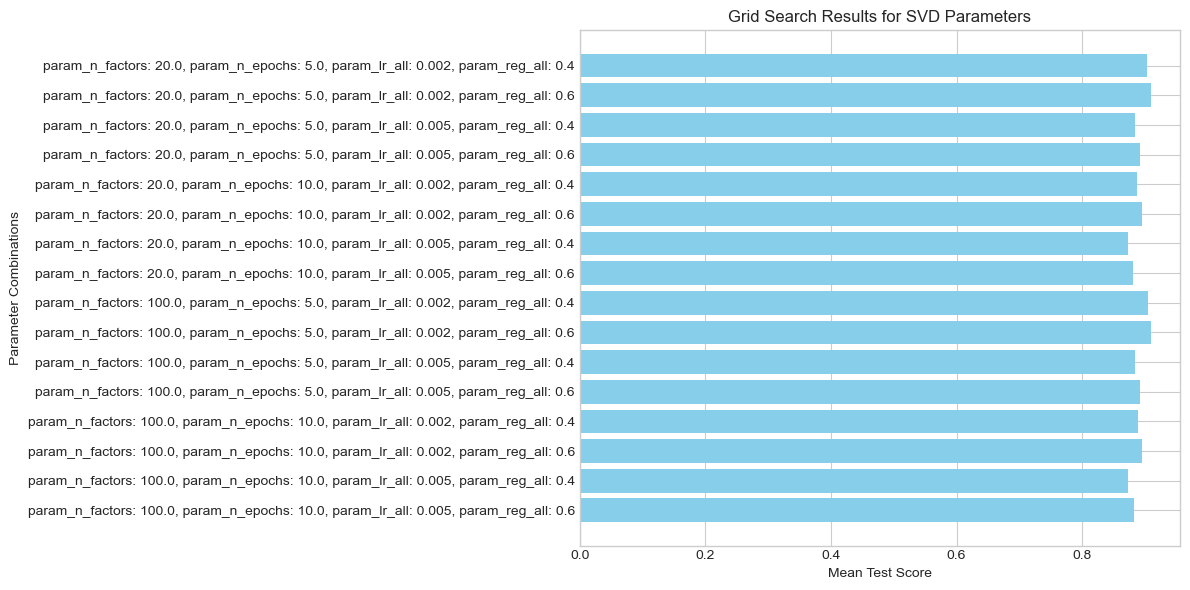

In [32]:
# Get the results of the grid search
results_df = pd.DataFrame.from_dict(gs_model.cv_results)

# Extract the parameter values and their corresponding mean test scores
param_cols = ['param_n_factors', 'param_n_epochs', 'param_lr_all', 'param_reg_all']
mean_test_scores = results_df['mean_test_rmse']

# Create a list of parameter combinations as strings
param_combinations = [', '.join([f"{param}: {value}" for param, value in zip(param_cols, params)]) for params in results_df[param_cols].values]

# Create a bar plot to visualize the results
plt.figure(figsize=(12, 6))
plt.barh(param_combinations, mean_test_scores, color='skyblue')
plt.xlabel('Mean Test Score')
plt.ylabel('Parameter Combinations')
plt.title('Grid Search Results for SVD Parameters')
plt.gca().invert_yaxis()  # Invert the y-axis to show the best results at the top
plt.tight_layout()

# Display the plot
plt.show()

From the above analysis, we can see that the best performing model with the best parameters is the SVD model with the parameters n_factors = 20 and a learning rate of 0.05. The RMSE decreses significantly with cross validating especially with the KNNBaseline because it adds a bias term by way of minimizing the cost function.

### 5.2. MAKING RECOMMENDATIONS.

### 5.2.1 MAKING PREDICTIONS

First we will fit our best performing model with the parameters that we evaluated above.

In [33]:
# initializing the model.
svd = SVD(n_factors = 20, n_epochs = 20, lr_all = 0.05, reg_all = 0.4)

In [34]:
# fitting the model to the training dataset.
svd.fit(dataset)

In [35]:
# make predictions for a specific user.
svd.predict(1,3)

Prediction(uid=1, iid=3, r_ui=None, est=3.789945937364609, details={'was_impossible': False})

prediction value is a tuple and each value can be accessed through indexing.

### 5.2.3. OBTAINING USER RATINGS.

Next, building a function that recommends movies to a user and asks the user to rate it if he/she has watched it or skip it if otherwise. The function should take in the following arguments, the movies dataframe that contains information about the movie, the rat which is an interger value for the rating as well as the genre for the option of picking a movie from a specific genre.

In [36]:
ratings_df['userId'].max()

610

In [37]:
def rater(movie_df, rat, genre = None):
    rating_list = []

    # Define a user ID for rating submissions
    user_id = 700

    # Filter movies by genre if specified
    if genre:
        movie_df = movie_df[movie_df['genres'].str.contains(genre)]

    # Randomly select and present movies for rating
    for _ in range(rat):
        # Select a random movie
        random_movie = movie_df.sample(1)

        # Get the movie's title and ID
        movie_title = random_movie['title'].values[0]
        movie_id = random_movie['movieId'].values[0]

        # Present the movie to the user
        print(f"Movie: {movie_title}")
        user_rating = input("Rate this movie on a scale from 1 to 5 (or type 'skip' to skip): ")

        # Check if the user wants to skip rating
        if user_rating.lower() == 'skip':
            continue

        try:
            user_rating = float(user_rating)
            if user_rating < 1 or user_rating > 5:
                print("Invalid rating. Please enter a rating between 1 and 5.")
                continue
        except ValueError:
            print("Invalid input. Please enter a number between 1 and 5 or 'skip'.")
            continue

        # Increment the user ID for each rating submission
        user_id += 1

        # Create a dictionary with the user's rating
        rating_dict = {'userId': user_id, 'movieId': movie_id, 'rating': user_rating}

        # Append the rating to the list
        rating_list.append(rating_dict)

    return rating_list

In [38]:
user_rating = rater(movies_df, 4, 'Comedy')

Movie: Frequently Asked Questions About Time Travel (2009)
Rate this movie on a scale from 1 to 5 (or type 'skip' to skip): 1
Movie: Bad Asses on the Bayou (2015)
Rate this movie on a scale from 1 to 5 (or type 'skip' to skip): 2
Movie: Made of Honor (2008)
Rate this movie on a scale from 1 to 5 (or type 'skip' to skip): 3
Movie: Sarah Silverman: Jesus Is Magic (2005)
Rate this movie on a scale from 1 to 5 (or type 'skip' to skip): 4


Next step is to make predictions for the new user using this new ratings

In [39]:
## add the new ratings to the original ratings DataFrame
user_ratings = pd.DataFrame(user_rating)

In [40]:
# concat the new dataframe with the older dataframe
new_ratings_df = pd.concat([user_ratings, ratings_df], axis = 0)

In [41]:
# read in values as Surprise dataset 
# Create a Reader object to specify the rating scale
reader = Reader(rating_scale=(1, 5))  # Adjust the rating scale if needed

# Load data from the DataFrame into the Surprise Dataset
new_data = Dataset.load_from_df(new_ratings_df, reader)

In [42]:
# build training set for our recommendation system.
new_dataset = new_data.build_full_trainset()
print('Number of users: ', new_dataset.n_users)

print('Number of items: ', new_dataset.n_items)

Number of users:  614
Number of items:  9724


In [43]:
# train a model using the new combined DataFrame
# initializing the model.
svd_1 = SVD(n_factors = 20, n_epochs = 20, lr_all = 0.05, reg_all = 0.4)

# fitting the model to the training dataset.
svd_1.fit(new_dataset)

In [44]:
# replace user_id with the user you want to make predictions for.
# find all the unrated movies
user_id = 700
new_user_movie_ids = new_ratings_df[new_ratings_df['userId'] == user_id]['movieId']
all_movie_ids = new_ratings_df['movieId'].unique()
unrated_movie_ids = [movie_id for movie_id in all_movie_ids if movie_id not in new_user_movie_ids]

In [45]:
# make predictions for the unrated movies.
predictions = []
for movie_id in unrated_movie_ids:
    prediction = svd_1.predict(user_id, movie_id)
    predictions.append((movie_id, prediction.est))

In [46]:
# sort the predictions in descending order.
predictions.sort(key=lambda x: x[1], reverse=True)

In [47]:
# Make top 10 recommendations.
N = 10
top_n_recommendations = predictions[:N]

#print the top N movie reccomendations.
for movie_id, predicted_rating in top_n_recommendations:
    movie_title = movies_df[movies_df['movieId'] == movie_id]['title'].values[0]
    print('Movie:', movie_title)     
    print('Predicted Rating',predicted_rating)
    print('\n')

Movie: Seve (2014)
Predicted Rating 4.76628156973784


Movie: Match Factory Girl, The (Tulitikkutehtaan tyttö) (1990)
Predicted Rating 4.720045779869199


Movie: Come and See (Idi i smotri) (1985)
Predicted Rating 4.678782240463515


Movie: Bossa Nova (2000)
Predicted Rating 4.636630399479271


Movie: Villain (1971)
Predicted Rating 4.590086096268687


Movie: Unfaithfully Yours (1948)
Predicted Rating 4.5880289947979636


Movie: Galaxy of Terror (Quest) (1981)
Predicted Rating 4.554087837667336


Movie: Little Murders (1971)
Predicted Rating 4.541156091018713


Movie: Jetée, La (1962)
Predicted Rating 4.538242073010832


Movie: Lamerica (1994)
Predicted Rating 4.533071134072497




Our model successfully used collaborative filtering and gave predictions, ie, recommendations of top 10 movies that the new user based on user-user similarity.

## 6. CONCLUSIONS 

. Effectiveness of collaborative filtering method, In this project I used user-user similarity which proved to be the right approach to take since there were fewer users than items. However there consists other methods like content based filtering are good approaches which can be customized to suit user preferences. 

. I used the singular value decompositions and generated a grid search in pursuit of the best parameters in order to make right predictions and cross validated using the KNNBasic and the KNNBaseline, the latter yielded better results in reducing the test rmse after making predictions. The optimum parameters were, n_factors = 20, n_epochs = 20, lr_all = 0.05, reg_all = 0.4 respectively.

. Implementing user friendly interfaces increases the chance of users rating a movie thus makes collection of metadata easier in order to provide insightful recommendations suited to the liking of the user.

. When working with a large dataset it is important to have adequate memory or use a sample of the data that is representative of the whole to make predictions, however using the entire dataset would yield better results since it is training and learning from a huge datset which makes it easier to make accurate predictions, consequently it is important to be cautious not to overfit.

## 7. RECOMMENDATIONS.

. To address the cold start problem, that is, the system finds it difficult to make recommendations for users or items that have fewer interactions with it. Content-based methods and hybrid recommendation systems can address this issue by incorporating item features and metadata. 

. The performance of recommendation system depends on hyperparameter settings. Careful tuning of hyperparameters, such as the number of neighbors (k) in KNN or the regularization term in matrix factorization, is essential for optimal results. This can be done by using a grid search that takes in a range of values for different parameters and find the best parameters based on the problem at hand.

. To determine the recommendation system's performance it is important to use evaluation metrics, common metrics include Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), F1 score among others. These metrics help you to guage how the system is performing and how to improve its prformance if it is low.

. The user experience should be a priority. Implement user-friendly interfaces that allow users to provide feedback, rate items, and refine their preferences. User feedback can be used to continuously improve recommendations.

. Ensure that the recommendation system has good security, this ensures trust between users and the system is built where they are guaranteed their information is kept safe, private or even anonymized.

. Hybrid recommendation systems are a great way to improve the performance of the system. These systems incorporate collaborative filtering, content-based filtering, and other techniques, however hese types require adequate memory in order to be able to run well.

. The recommendation system should be flexible in that they can correctly make recommendations even with changes either from the user's preferences or even accomodating new users.